In [1]:
# !pip install mne

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from scipy.signal import argrelextrema, welch
from scipy.integrate import cumtrapz
import statistics
import time

import mne # to read the .edf files

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

In [2]:
from sklearn.utils.class_weight import compute_class_weight

# Preprocessing

In [3]:
# some pre-processing used function from pyeeg

def bin_power(X, Band, Fs):
    """Compute power in each frequency bin specified by Band from FFT result of

    Parameters
    -----------

    X: list: a 1-D real time series.
    Band; list
        boundary frequencies (in Hz) of bins. They can be unequal bins, e.g.
        [0.5,4,7,12,30] which are delta, theta, alpha and beta respectively.
        You can also use range() function of Python to generate equal bins and
        pass the generated list to this function.

        Each element of Band is a physical frequency and shall not exceed the
        Nyquist frequency, i.e., half of sampling frequency.



    Fs: integer: the sampling rate in physical frequency

    Returns
    -------

    Power: list: spectral power in each frequency bin.

    Power_ratio: list:
        spectral power in each frequency bin normalized by total power in ALL
        frequency bins.

    """

    C = np.fft.fft(X)
    C = abs(C)
    Power = np.zeros(len(Band) - 1)
    for Freq_Index in range(0, len(Band) - 1):
        Freq = float(Band[Freq_Index])
        Next_Freq = float(Band[Freq_Index + 1])
        Power[Freq_Index] = sum(
            C[int(np.floor(Freq / Fs * len(X))):
                int(np.floor(Next_Freq / Fs * len(X)))]
        )
    Power_Ratio = Power / sum(Power)
    return Power, Power_Ratio


def hfd(X, Kmax):
    """ Compute Higuchi Fractal Dimension of a time series X. kmax
     is an HFD parameter
    """
    L = []
    x = []
    N = len(X)
    for k in range(1, Kmax):
        Lk = []
        for m in range(0, k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += abs(X[m + i * k] - X[m + i * k - k])
            Lmk = Lmk * (N - 1) / np.floor((N - m) / float(k)) / k
            Lk.append(Lmk)
        L.append(np.log(np.mean(Lk)))
        x.append([np.log(float(1) / k), 1])

    (p, _, _, _) = np.linalg.lstsq(x, L)
    return p[0]



def pfd(X, D=None):
    """Compute Petrosian Fractal Dimension of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, the first order differential sequence of X (if D is provided,
           recommended to speed up)

    In case 1, D is computed using Numpy's difference function.

    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.
    """
    if D is None:
        D = np.diff(X)
        D = D.tolist()
    N_delta = 0  # number of sign changes in derivative of the signal
    for i in range(1, len(D)):
        if D[i] * D[i - 1] < 0:
            N_delta += 1
    n = len(X)
    return np.log10(n) / (
        np.log10(n) + np.log10(n / n + 0.4 * N_delta)
    )


def hurst(X):
    """ Compute the Hurst exponent of X. If the output H=0.5,the behavior
    of the time-series is similar to random walk. If H<0.5, the time-series
    cover less "distance" than a random walk, vice verse.

    Parameters
    ----------

    X: list: a time series

    Returns
    -------
    H: float:  Hurst exponent
    """
    X = np.array(X)
    N = X.size
    T = np.arange(1, N + 1)
    Y = np.cumsum(X)
    Ave_T = Y / T

    S_T = np.zeros(N)
    R_T = np.zeros(N)

    for i in range(N):
        S_T[i] = np.std(X[:i + 1])
        X_T = Y - T * Ave_T[i]
        R_T[i] = np.ptp(X_T[:i + 1])

    R_S = R_T / S_T
    R_S = np.log(R_S)[1:]
    n = np.log(T)[1:]
    A = np.column_stack((n, np.ones(n.size)))
    [m, c] = np.linalg.lstsq(A, R_S)[0]
    H = m
    return H


def spectral_entropy(X, Band, Fs, Power_Ratio=None):
    """Compute spectral entropy of a time series from either two cases below:
    1. X, the time series (default)
    2. Power_Ratio, a list of normalized signal power in a set of frequency
    bins defined in Band (if Power_Ratio is provided, recommended to speed up)

    In case 1, Power_Ratio is computed by bin_power() function.

    Notes
    -----
    To speed up, it is recommended to compute Power_Ratio before calling this
    function because it may also be used by other functions whereas computing
    it here again will slow down.

    Parameters
    ----------

    X: list: a 1-D real time series.

    Band: list

        boundary frequencies (in Hz) of bins. They can be unequal bins, e.g.
        [0.5,4,7,12,30] which are delta, theta, alpha and beta respectively.
        You can also use range() function of Python to generate equal bins and
        pass the generated list to this function.

        Each element of Band is a physical frequency and shall not exceed the
        Nyquist frequency, i.e., half of sampling frequency.


    Fs: integer: the sampling rate in physical frequency

    Returns
    -------

    As indicated in return line

    See Also
    --------
    bin_power: pyeeg function that computes spectral power in frequency bins

    """

    if Power_Ratio is None:
        Power, Power_Ratio = bin_power(X, Band, Fs)

    Spectral_Entropy = 0
    for i in range(0, len(Power_Ratio) - 1):
        Spectral_Entropy += Power_Ratio[i] * np.log(Power_Ratio[i])
    Spectral_Entropy /= np.log(
        len(Power_Ratio)
    )  # to save time, minus one is omitted
    return -1 * Spectral_Entropy


def hjorth(X, D=None):
    """ Compute Hjorth mobility and complexity of a time series from either two
    cases below:
        1. X, the time series of type list (default)
        2. D, a first order differential sequence of X (if D is provided,
           recommended to speed up)

    In case 1, D is computed using Numpy's Difference function.

    Notes
    -----
    To speed up, it is recommended to compute D before calling this function
    because D may also be used by other functions whereas computing it here
    again will slow down.

    Parameters
    ----------

    X: list: a time series

    D: list: first order differential sequence of a time series

    Returns
    -------

    As indicated in return line

    Hjorth mobility and complexity

    """

    if D is None:
        D = np.diff(X)
        D = D.tolist()

    D.insert(0, X[0])  # pad the first difference
    D = np.array(D)

    n = len(X)

    M2 = float(sum(D ** 2)) / n
    TP = sum(np.array(X) ** 2)
    M4 = 0
    for i in range(1, len(D)):
        M4 += (D[i] - D[i - 1]) ** 2
    M4 = M4 / n

    return np.sqrt(M2 / TP), np.sqrt(
        float(M4) * TP / M2 / M2
    )  # Hjorth Mobility and Complexity

In [4]:
# read the edf and print stuff first
# def eeg_visualize(file, start_time, end_time):
def eeg_visualize(file):
    raw = mne.io.read_raw_edf(file)
    n = 2

    # MNE-Python's interactive data browser to get a better visualization
    raw.plot()

    # select a time frame
    start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
    temp, times = raw[:, start:stop]
    fig, axs = plt.subplots(n)
    fig.suptitle('Patient EEG')
    plt.xlabel('time (s)')
    plt.ylabel('MEG data (T)')
    for i in range(n):
        axs[i].plot(times, temp[i].T)
    plt.show()

In [5]:
# feature extracting process
def eeg_features(data):
    data = np.asarray(data)
    res  = np.zeros([22])
    Kmax = 5
    # M    = 10
    # R    = 0.3
    Band = [1,5,10,15,20,25]
    Fs   = 256
    power, power_ratio = bin_power(data, Band, Fs)
    f, P = welch(data, fs=Fs, window='hann', noverlap=0, nfft=int(256.))       # Signal power spectrum
    area_freq = cumtrapz(P, f, initial=0)
    res[0] = np.sqrt(np.sum(np.power(data, 2)) / data.shape[0])                   # amplitude RMS
    res[1] = statistics.stdev(data)**2                                            # variance
    res[2] = kurtosis(data)                                                       # kurtosis
    res[3] = skew(data)                                                           # skewness
    res[4] = max(data)                                                            # max amplitude
    res[5] = min(data)                                                            # min amplitude
    res[6] = len(argrelextrema(data, np.greater)[0])                              # number of local extrema or peaks
    res[7] = ((data[:-1] * data[1:]) < 0).sum()                                   # number of zero crossings
    res[8] = hfd(data, Kmax)                                                      # Higuchi Fractal Dimension
    res[9] = pfd(data)                                                            # Petrosian Fractal Dimension
    res[10] = hurst(data)                                                         # Hurst exponent
    res[11] = spectral_entropy(data, Band, Fs, Power_Ratio=power_ratio)           # spectral entropy (1.21s)
    res[12] = area_freq[-1]                                                       # total power
    res[13] = f[np.where(area_freq >= res[12] / 2)[0][0]]                         # median frequency
    res[14] = f[np.argmax(P)]                                                     # peak frequency
    res[15], res[16] = hjorth(data)                                               # Hjorth mobility and complexity
    res[17] = power_ratio[0]
    res[18] = power_ratio[1]
    res[19] = power_ratio[2]
    res[20] = power_ratio[3]
    res[21] = power_ratio[4]
    # res[22] = pyeeg.samp_entropy(data, M, R)             # sample entropy
    # res[23] = pyeeg.ap_entropy(data, M, R)             # approximate entropy (1.14s)
    return (res)


In [6]:
# eeg pre-processing
def eeg_preprocessing(file, seizures, epoch_length = 10, step_size = 1, start_time = 0):
    start = time.time()

    # reading in data
    raw = mne.io.read_raw_edf(file)

    # apply filterbank
    raw = raw.load_data().filter(l_freq=0.25, h_freq=25)
    channels = raw.ch_names                                  # column names

    # Divide into epochs
    res = []
    while start_time <= max(raw.times) + 0.01 - epoch_length:  # max(raw.times) = 3600
#     while start_time <= 50 - epoch_length:  # max(raw.times) = 3600
        features = []
        start, stop = raw.time_as_index([start_time, start_time + epoch_length])
        temp = raw[:, start:stop][0]

        # start time as ID
        features.append(start_time)

        # features
        for i in range(23):
            features.extend(eeg_features(temp[i]).tolist())

        # seizure flag for y
        if file in seizures:  # if file has seizure
            for seizure in seizures[file]:
                if start_time > seizure[0] and start_time < seizure[1]:
                    features.append(1)
                elif start_time + epoch_length > seizure[0] and start_time + epoch_length < seizure[1]:
                    features.append(1)
                else:
                    features.append(0)
        else:
            features.append(0)

        res.append(features)
        start_time += step_size
        print("Section ", str(len(res)), "; start: ", start, " ; stop: ", stop)

    # formatting
    feature_names = ["rms", "variance", "kurtosis", "skewness", "max_amp", "min_amp", "n_peaks", "n_crossings",
        "hfd", "pfd", "hurst_exp", "spectral_entropy", "total_power", "median_freq", "peak_freq",
        "hjorth_mobility", "hjorth_complexity", "power_1hz", "power_5hz", "power_10hz", "power_15hz", "power_20hz"]

    column_names = ["start_time"]
    for channel in channels:
        for name in feature_names:
            column_names.append(channel + "_" + name)
    column_names.append("seizure")

    res = pd.DataFrame(res, columns=column_names)

    end = time.time()
    print("Finished preprocessing ", file, f" took {(end - start) / 60} minutes")
    return res

# Reading and Preprocessing files

In [7]:
# doing patient chb01
seizures = {
    "chb_mit/data/chb01/chb01_03.edf": [[2996, 3036]], # start and end time of seizure
    "chb_mit/data/chb01/chb01_04.edf": [[1467, 1494]],
    "chb_mit/data/chb01/chb01_15.edf": [[1732, 1772]],
    "chb_mit/data/chb01/chb01_16.edf": [[1015, 1066]],
    "chb_mit/data/chb01/chb01_18.edf": [[1720, 1810]],
    "chb_mit/data/chb01/chb01_21.edf": [[327, 420]],
    "chb_mit/data/chb01/chb01_26.edf": [[1862, 1963]]
}
files = ["chb_mit/data/chb01/chb01_03.edf",
        "chb_mit/data/chb01/chb01_04.edf",
        "chb_mit/data/chb01/chb01_15.edf",
        "chb_mit/data/chb01/chb01_16.edf",
        "chb_mit/data/chb01/chb01_18.edf",
        "chb_mit/data/chb01/chb01_21.edf",
        "chb_mit/data/chb01/chb01_26.edf"]


# files = ["chb01_01.edf", "chb01_02.edf", "chb01_03.edf", "chb01_04.edf", "chb01_05.edf",
#          "chb01_06.edf", "chb01_07.edf", "chb01_08.edf", "chb01_09.edf", "chb01_10.edf",
#          "chb01_11.edf", "chb01_12.edf", "chb01_13.edf", "chb01_14.edf", "chb01_15.edf",
#          "chb01_16.edf", "chb01_17.edf", "chb01_18.edf", "chb01_19.edf", "chb01_20.edf",
#          "chb01_21.edf", "chb01_22.edf", "chb01_23.edf", "chb01_24.edf", "chb01_25.edf",
#          "chb01_26.edf", "chb01_27.edf", "chb01_28.edf", "chb01_29.edf", "chb01_30.edf",
#          "chb01_31.edf", "chb01_32.edf", "chb01_33.edf", "chb01_34.edf", "chb01_35.edf",
#          "chb01_36.edf", "chb01_37.edf", "chb01_38.edf", "chb01_39.edf", "chb01_40.edf",
#          "chb01_41.edf", "chb01_42.edf", "chb01_43.edf", "chb01_44.edf", "chb01_45.edf",
#          "chb01_46.edf"]

In [8]:
file1 = "chb_mit/data/chb01/chb01_01.edf"
res = eeg_preprocessing(file1, seizures)
for file in files:
    int_res = eeg_preprocessing(file, seizures)
    res = pd.concat([res, int_res], ignore_index=True)

Extracting EDF parameters from /home/iris/Desktop/chb_mit/data/chb01/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(A, R_S)[0]


Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

Section  2437 ; start:  623616  ; stop:  626176
Section  2438 ; start:  623872  ; stop:  626432
Section  2439 ; start:  624128  ; stop:  626688
Section  2440 ; start:  624384  ; stop:  626944
Section  2441 ; start:  624640  ; stop:  627200
Section  2442 ; start:  624896  ; stop:  627456
Section  2443 ; start:  625152  ; stop:  627712
Section  2444 ; start:  625408  ; stop:  627968
Section  2445 ; start:  625664  ; stop:  628224
Section  2446 ; start:  625920  ; stop:  628480
Section  2447 ; start:  626176  ; stop:  628736
Section  2448 ; start:  626432  ; stop:  628992
Section  2449 ; start:  626688  ; stop:  629248
Section  2450 ; start:  626944  ; stop:  629504
Section  2451 ; start:  627200  ; stop:  629760
Section  2452 ; start:  627456  ; stop:  630016
Section  2453 ; start:  627712  ; stop:  630272
Section  2454 ; start:  627968  ; stop:  630528
Section  2455 ; start:  628224  ; stop:  630784
Section  2456 ; start:  628480  ; stop:  631040
Section  2457 ; start:  628736  ; stop: 

Section  2608 ; start:  667392  ; stop:  669952
Section  2609 ; start:  667648  ; stop:  670208
Section  2610 ; start:  667904  ; stop:  670464
Section  2611 ; start:  668160  ; stop:  670720
Section  2612 ; start:  668416  ; stop:  670976
Section  2613 ; start:  668672  ; stop:  671232
Section  2614 ; start:  668928  ; stop:  671488
Section  2615 ; start:  669184  ; stop:  671744
Section  2616 ; start:  669440  ; stop:  672000
Section  2617 ; start:  669696  ; stop:  672256
Section  2618 ; start:  669952  ; stop:  672512
Section  2619 ; start:  670208  ; stop:  672768
Section  2620 ; start:  670464  ; stop:  673024
Section  2621 ; start:  670720  ; stop:  673280
Section  2622 ; start:  670976  ; stop:  673536
Section  2623 ; start:  671232  ; stop:  673792
Section  2624 ; start:  671488  ; stop:  674048
Section  2625 ; start:  671744  ; stop:  674304
Section  2626 ; start:  672000  ; stop:  674560
Section  2627 ; start:  672256  ; stop:  674816
Section  2628 ; start:  672512  ; stop: 

Section  2779 ; start:  711168  ; stop:  713728
Section  2780 ; start:  711424  ; stop:  713984
Section  2781 ; start:  711680  ; stop:  714240
Section  2782 ; start:  711936  ; stop:  714496
Section  2783 ; start:  712192  ; stop:  714752
Section  2784 ; start:  712448  ; stop:  715008
Section  2785 ; start:  712704  ; stop:  715264
Section  2786 ; start:  712960  ; stop:  715520
Section  2787 ; start:  713216  ; stop:  715776
Section  2788 ; start:  713472  ; stop:  716032
Section  2789 ; start:  713728  ; stop:  716288
Section  2790 ; start:  713984  ; stop:  716544
Section  2791 ; start:  714240  ; stop:  716800
Section  2792 ; start:  714496  ; stop:  717056
Section  2793 ; start:  714752  ; stop:  717312
Section  2794 ; start:  715008  ; stop:  717568
Section  2795 ; start:  715264  ; stop:  717824
Section  2796 ; start:  715520  ; stop:  718080
Section  2797 ; start:  715776  ; stop:  718336
Section  2798 ; start:  716032  ; stop:  718592
Section  2799 ; start:  716288  ; stop: 

Section  2950 ; start:  754944  ; stop:  757504
Section  2951 ; start:  755200  ; stop:  757760
Section  2952 ; start:  755456  ; stop:  758016
Section  2953 ; start:  755712  ; stop:  758272
Section  2954 ; start:  755968  ; stop:  758528
Section  2955 ; start:  756224  ; stop:  758784
Section  2956 ; start:  756480  ; stop:  759040
Section  2957 ; start:  756736  ; stop:  759296
Section  2958 ; start:  756992  ; stop:  759552
Section  2959 ; start:  757248  ; stop:  759808
Section  2960 ; start:  757504  ; stop:  760064
Section  2961 ; start:  757760  ; stop:  760320
Section  2962 ; start:  758016  ; stop:  760576
Section  2963 ; start:  758272  ; stop:  760832
Section  2964 ; start:  758528  ; stop:  761088
Section  2965 ; start:  758784  ; stop:  761344
Section  2966 ; start:  759040  ; stop:  761600
Section  2967 ; start:  759296  ; stop:  761856
Section  2968 ; start:  759552  ; stop:  762112
Section  2969 ; start:  759808  ; stop:  762368
Section  2970 ; start:  760064  ; stop: 

Section  3121 ; start:  798720  ; stop:  801280
Section  3122 ; start:  798976  ; stop:  801536
Section  3123 ; start:  799232  ; stop:  801792
Section  3124 ; start:  799488  ; stop:  802048
Section  3125 ; start:  799744  ; stop:  802304
Section  3126 ; start:  800000  ; stop:  802560
Section  3127 ; start:  800256  ; stop:  802816
Section  3128 ; start:  800512  ; stop:  803072
Section  3129 ; start:  800768  ; stop:  803328
Section  3130 ; start:  801024  ; stop:  803584
Section  3131 ; start:  801280  ; stop:  803840
Section  3132 ; start:  801536  ; stop:  804096
Section  3133 ; start:  801792  ; stop:  804352
Section  3134 ; start:  802048  ; stop:  804608
Section  3135 ; start:  802304  ; stop:  804864
Section  3136 ; start:  802560  ; stop:  805120
Section  3137 ; start:  802816  ; stop:  805376
Section  3138 ; start:  803072  ; stop:  805632
Section  3139 ; start:  803328  ; stop:  805888
Section  3140 ; start:  803584  ; stop:  806144
Section  3141 ; start:  803840  ; stop: 

Section  3292 ; start:  842496  ; stop:  845056
Section  3293 ; start:  842752  ; stop:  845312
Section  3294 ; start:  843008  ; stop:  845568
Section  3295 ; start:  843264  ; stop:  845824
Section  3296 ; start:  843520  ; stop:  846080
Section  3297 ; start:  843776  ; stop:  846336
Section  3298 ; start:  844032  ; stop:  846592
Section  3299 ; start:  844288  ; stop:  846848
Section  3300 ; start:  844544  ; stop:  847104
Section  3301 ; start:  844800  ; stop:  847360
Section  3302 ; start:  845056  ; stop:  847616
Section  3303 ; start:  845312  ; stop:  847872
Section  3304 ; start:  845568  ; stop:  848128
Section  3305 ; start:  845824  ; stop:  848384
Section  3306 ; start:  846080  ; stop:  848640
Section  3307 ; start:  846336  ; stop:  848896
Section  3308 ; start:  846592  ; stop:  849152
Section  3309 ; start:  846848  ; stop:  849408
Section  3310 ; start:  847104  ; stop:  849664
Section  3311 ; start:  847360  ; stop:  849920
Section  3312 ; start:  847616  ; stop: 

Section  3463 ; start:  886272  ; stop:  888832
Section  3464 ; start:  886528  ; stop:  889088
Section  3465 ; start:  886784  ; stop:  889344
Section  3466 ; start:  887040  ; stop:  889600
Section  3467 ; start:  887296  ; stop:  889856
Section  3468 ; start:  887552  ; stop:  890112
Section  3469 ; start:  887808  ; stop:  890368
Section  3470 ; start:  888064  ; stop:  890624
Section  3471 ; start:  888320  ; stop:  890880
Section  3472 ; start:  888576  ; stop:  891136
Section  3473 ; start:  888832  ; stop:  891392
Section  3474 ; start:  889088  ; stop:  891648
Section  3475 ; start:  889344  ; stop:  891904
Section  3476 ; start:  889600  ; stop:  892160
Section  3477 ; start:  889856  ; stop:  892416
Section  3478 ; start:  890112  ; stop:  892672
Section  3479 ; start:  890368  ; stop:  892928
Section  3480 ; start:  890624  ; stop:  893184
Section  3481 ; start:  890880  ; stop:  893440
Section  3482 ; start:  891136  ; stop:  893696
Section  3483 ; start:  891392  ; stop: 

/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(A, R_S)[0]


Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

Section  2437 ; start:  623616  ; stop:  626176
Section  2438 ; start:  623872  ; stop:  626432
Section  2439 ; start:  624128  ; stop:  626688
Section  2440 ; start:  624384  ; stop:  626944
Section  2441 ; start:  624640  ; stop:  627200
Section  2442 ; start:  624896  ; stop:  627456
Section  2443 ; start:  625152  ; stop:  627712
Section  2444 ; start:  625408  ; stop:  627968
Section  2445 ; start:  625664  ; stop:  628224
Section  2446 ; start:  625920  ; stop:  628480
Section  2447 ; start:  626176  ; stop:  628736
Section  2448 ; start:  626432  ; stop:  628992
Section  2449 ; start:  626688  ; stop:  629248
Section  2450 ; start:  626944  ; stop:  629504
Section  2451 ; start:  627200  ; stop:  629760
Section  2452 ; start:  627456  ; stop:  630016
Section  2453 ; start:  627712  ; stop:  630272
Section  2454 ; start:  627968  ; stop:  630528
Section  2455 ; start:  628224  ; stop:  630784
Section  2456 ; start:  628480  ; stop:  631040
Section  2457 ; start:  628736  ; stop: 

Section  2608 ; start:  667392  ; stop:  669952
Section  2609 ; start:  667648  ; stop:  670208
Section  2610 ; start:  667904  ; stop:  670464
Section  2611 ; start:  668160  ; stop:  670720
Section  2612 ; start:  668416  ; stop:  670976
Section  2613 ; start:  668672  ; stop:  671232
Section  2614 ; start:  668928  ; stop:  671488
Section  2615 ; start:  669184  ; stop:  671744
Section  2616 ; start:  669440  ; stop:  672000
Section  2617 ; start:  669696  ; stop:  672256
Section  2618 ; start:  669952  ; stop:  672512
Section  2619 ; start:  670208  ; stop:  672768
Section  2620 ; start:  670464  ; stop:  673024
Section  2621 ; start:  670720  ; stop:  673280
Section  2622 ; start:  670976  ; stop:  673536
Section  2623 ; start:  671232  ; stop:  673792
Section  2624 ; start:  671488  ; stop:  674048
Section  2625 ; start:  671744  ; stop:  674304
Section  2626 ; start:  672000  ; stop:  674560
Section  2627 ; start:  672256  ; stop:  674816
Section  2628 ; start:  672512  ; stop: 

Section  2779 ; start:  711168  ; stop:  713728
Section  2780 ; start:  711424  ; stop:  713984
Section  2781 ; start:  711680  ; stop:  714240
Section  2782 ; start:  711936  ; stop:  714496
Section  2783 ; start:  712192  ; stop:  714752
Section  2784 ; start:  712448  ; stop:  715008
Section  2785 ; start:  712704  ; stop:  715264
Section  2786 ; start:  712960  ; stop:  715520
Section  2787 ; start:  713216  ; stop:  715776
Section  2788 ; start:  713472  ; stop:  716032
Section  2789 ; start:  713728  ; stop:  716288
Section  2790 ; start:  713984  ; stop:  716544
Section  2791 ; start:  714240  ; stop:  716800
Section  2792 ; start:  714496  ; stop:  717056
Section  2793 ; start:  714752  ; stop:  717312
Section  2794 ; start:  715008  ; stop:  717568
Section  2795 ; start:  715264  ; stop:  717824
Section  2796 ; start:  715520  ; stop:  718080
Section  2797 ; start:  715776  ; stop:  718336
Section  2798 ; start:  716032  ; stop:  718592
Section  2799 ; start:  716288  ; stop: 

Section  2950 ; start:  754944  ; stop:  757504
Section  2951 ; start:  755200  ; stop:  757760
Section  2952 ; start:  755456  ; stop:  758016
Section  2953 ; start:  755712  ; stop:  758272
Section  2954 ; start:  755968  ; stop:  758528
Section  2955 ; start:  756224  ; stop:  758784
Section  2956 ; start:  756480  ; stop:  759040
Section  2957 ; start:  756736  ; stop:  759296
Section  2958 ; start:  756992  ; stop:  759552
Section  2959 ; start:  757248  ; stop:  759808
Section  2960 ; start:  757504  ; stop:  760064
Section  2961 ; start:  757760  ; stop:  760320
Section  2962 ; start:  758016  ; stop:  760576
Section  2963 ; start:  758272  ; stop:  760832
Section  2964 ; start:  758528  ; stop:  761088
Section  2965 ; start:  758784  ; stop:  761344
Section  2966 ; start:  759040  ; stop:  761600
Section  2967 ; start:  759296  ; stop:  761856
Section  2968 ; start:  759552  ; stop:  762112
Section  2969 ; start:  759808  ; stop:  762368
Section  2970 ; start:  760064  ; stop: 

Section  3121 ; start:  798720  ; stop:  801280
Section  3122 ; start:  798976  ; stop:  801536
Section  3123 ; start:  799232  ; stop:  801792
Section  3124 ; start:  799488  ; stop:  802048
Section  3125 ; start:  799744  ; stop:  802304
Section  3126 ; start:  800000  ; stop:  802560
Section  3127 ; start:  800256  ; stop:  802816
Section  3128 ; start:  800512  ; stop:  803072
Section  3129 ; start:  800768  ; stop:  803328
Section  3130 ; start:  801024  ; stop:  803584
Section  3131 ; start:  801280  ; stop:  803840
Section  3132 ; start:  801536  ; stop:  804096
Section  3133 ; start:  801792  ; stop:  804352
Section  3134 ; start:  802048  ; stop:  804608
Section  3135 ; start:  802304  ; stop:  804864
Section  3136 ; start:  802560  ; stop:  805120
Section  3137 ; start:  802816  ; stop:  805376
Section  3138 ; start:  803072  ; stop:  805632
Section  3139 ; start:  803328  ; stop:  805888
Section  3140 ; start:  803584  ; stop:  806144
Section  3141 ; start:  803840  ; stop: 

Section  3292 ; start:  842496  ; stop:  845056
Section  3293 ; start:  842752  ; stop:  845312
Section  3294 ; start:  843008  ; stop:  845568
Section  3295 ; start:  843264  ; stop:  845824
Section  3296 ; start:  843520  ; stop:  846080
Section  3297 ; start:  843776  ; stop:  846336
Section  3298 ; start:  844032  ; stop:  846592
Section  3299 ; start:  844288  ; stop:  846848
Section  3300 ; start:  844544  ; stop:  847104
Section  3301 ; start:  844800  ; stop:  847360
Section  3302 ; start:  845056  ; stop:  847616
Section  3303 ; start:  845312  ; stop:  847872
Section  3304 ; start:  845568  ; stop:  848128
Section  3305 ; start:  845824  ; stop:  848384
Section  3306 ; start:  846080  ; stop:  848640
Section  3307 ; start:  846336  ; stop:  848896
Section  3308 ; start:  846592  ; stop:  849152
Section  3309 ; start:  846848  ; stop:  849408
Section  3310 ; start:  847104  ; stop:  849664
Section  3311 ; start:  847360  ; stop:  849920
Section  3312 ; start:  847616  ; stop: 

Section  3463 ; start:  886272  ; stop:  888832
Section  3464 ; start:  886528  ; stop:  889088
Section  3465 ; start:  886784  ; stop:  889344
Section  3466 ; start:  887040  ; stop:  889600
Section  3467 ; start:  887296  ; stop:  889856
Section  3468 ; start:  887552  ; stop:  890112
Section  3469 ; start:  887808  ; stop:  890368
Section  3470 ; start:  888064  ; stop:  890624
Section  3471 ; start:  888320  ; stop:  890880
Section  3472 ; start:  888576  ; stop:  891136
Section  3473 ; start:  888832  ; stop:  891392
Section  3474 ; start:  889088  ; stop:  891648
Section  3475 ; start:  889344  ; stop:  891904
Section  3476 ; start:  889600  ; stop:  892160
Section  3477 ; start:  889856  ; stop:  892416
Section  3478 ; start:  890112  ; stop:  892672
Section  3479 ; start:  890368  ; stop:  892928
Section  3480 ; start:  890624  ; stop:  893184
Section  3481 ; start:  890880  ; stop:  893440
Section  3482 ; start:  891136  ; stop:  893696
Section  3483 ; start:  891392  ; stop: 

/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(A, R_S)[0]


Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

Section  2437 ; start:  623616  ; stop:  626176
Section  2438 ; start:  623872  ; stop:  626432
Section  2439 ; start:  624128  ; stop:  626688
Section  2440 ; start:  624384  ; stop:  626944
Section  2441 ; start:  624640  ; stop:  627200
Section  2442 ; start:  624896  ; stop:  627456
Section  2443 ; start:  625152  ; stop:  627712
Section  2444 ; start:  625408  ; stop:  627968
Section  2445 ; start:  625664  ; stop:  628224
Section  2446 ; start:  625920  ; stop:  628480
Section  2447 ; start:  626176  ; stop:  628736
Section  2448 ; start:  626432  ; stop:  628992
Section  2449 ; start:  626688  ; stop:  629248
Section  2450 ; start:  626944  ; stop:  629504
Section  2451 ; start:  627200  ; stop:  629760
Section  2452 ; start:  627456  ; stop:  630016
Section  2453 ; start:  627712  ; stop:  630272
Section  2454 ; start:  627968  ; stop:  630528
Section  2455 ; start:  628224  ; stop:  630784
Section  2456 ; start:  628480  ; stop:  631040
Section  2457 ; start:  628736  ; stop: 

Section  2608 ; start:  667392  ; stop:  669952
Section  2609 ; start:  667648  ; stop:  670208
Section  2610 ; start:  667904  ; stop:  670464
Section  2611 ; start:  668160  ; stop:  670720
Section  2612 ; start:  668416  ; stop:  670976
Section  2613 ; start:  668672  ; stop:  671232
Section  2614 ; start:  668928  ; stop:  671488
Section  2615 ; start:  669184  ; stop:  671744
Section  2616 ; start:  669440  ; stop:  672000
Section  2617 ; start:  669696  ; stop:  672256
Section  2618 ; start:  669952  ; stop:  672512
Section  2619 ; start:  670208  ; stop:  672768
Section  2620 ; start:  670464  ; stop:  673024
Section  2621 ; start:  670720  ; stop:  673280
Section  2622 ; start:  670976  ; stop:  673536
Section  2623 ; start:  671232  ; stop:  673792
Section  2624 ; start:  671488  ; stop:  674048
Section  2625 ; start:  671744  ; stop:  674304
Section  2626 ; start:  672000  ; stop:  674560
Section  2627 ; start:  672256  ; stop:  674816
Section  2628 ; start:  672512  ; stop: 

Section  2779 ; start:  711168  ; stop:  713728
Section  2780 ; start:  711424  ; stop:  713984
Section  2781 ; start:  711680  ; stop:  714240
Section  2782 ; start:  711936  ; stop:  714496
Section  2783 ; start:  712192  ; stop:  714752
Section  2784 ; start:  712448  ; stop:  715008
Section  2785 ; start:  712704  ; stop:  715264
Section  2786 ; start:  712960  ; stop:  715520
Section  2787 ; start:  713216  ; stop:  715776
Section  2788 ; start:  713472  ; stop:  716032
Section  2789 ; start:  713728  ; stop:  716288
Section  2790 ; start:  713984  ; stop:  716544
Section  2791 ; start:  714240  ; stop:  716800
Section  2792 ; start:  714496  ; stop:  717056
Section  2793 ; start:  714752  ; stop:  717312
Section  2794 ; start:  715008  ; stop:  717568
Section  2795 ; start:  715264  ; stop:  717824
Section  2796 ; start:  715520  ; stop:  718080
Section  2797 ; start:  715776  ; stop:  718336
Section  2798 ; start:  716032  ; stop:  718592
Section  2799 ; start:  716288  ; stop: 

Section  2950 ; start:  754944  ; stop:  757504
Section  2951 ; start:  755200  ; stop:  757760
Section  2952 ; start:  755456  ; stop:  758016
Section  2953 ; start:  755712  ; stop:  758272
Section  2954 ; start:  755968  ; stop:  758528
Section  2955 ; start:  756224  ; stop:  758784
Section  2956 ; start:  756480  ; stop:  759040
Section  2957 ; start:  756736  ; stop:  759296
Section  2958 ; start:  756992  ; stop:  759552
Section  2959 ; start:  757248  ; stop:  759808
Section  2960 ; start:  757504  ; stop:  760064
Section  2961 ; start:  757760  ; stop:  760320
Section  2962 ; start:  758016  ; stop:  760576
Section  2963 ; start:  758272  ; stop:  760832
Section  2964 ; start:  758528  ; stop:  761088
Section  2965 ; start:  758784  ; stop:  761344
Section  2966 ; start:  759040  ; stop:  761600
Section  2967 ; start:  759296  ; stop:  761856
Section  2968 ; start:  759552  ; stop:  762112
Section  2969 ; start:  759808  ; stop:  762368
Section  2970 ; start:  760064  ; stop: 

Section  3121 ; start:  798720  ; stop:  801280
Section  3122 ; start:  798976  ; stop:  801536
Section  3123 ; start:  799232  ; stop:  801792
Section  3124 ; start:  799488  ; stop:  802048
Section  3125 ; start:  799744  ; stop:  802304
Section  3126 ; start:  800000  ; stop:  802560
Section  3127 ; start:  800256  ; stop:  802816
Section  3128 ; start:  800512  ; stop:  803072
Section  3129 ; start:  800768  ; stop:  803328
Section  3130 ; start:  801024  ; stop:  803584
Section  3131 ; start:  801280  ; stop:  803840
Section  3132 ; start:  801536  ; stop:  804096
Section  3133 ; start:  801792  ; stop:  804352
Section  3134 ; start:  802048  ; stop:  804608
Section  3135 ; start:  802304  ; stop:  804864
Section  3136 ; start:  802560  ; stop:  805120
Section  3137 ; start:  802816  ; stop:  805376
Section  3138 ; start:  803072  ; stop:  805632
Section  3139 ; start:  803328  ; stop:  805888
Section  3140 ; start:  803584  ; stop:  806144
Section  3141 ; start:  803840  ; stop: 

Section  3292 ; start:  842496  ; stop:  845056
Section  3293 ; start:  842752  ; stop:  845312
Section  3294 ; start:  843008  ; stop:  845568
Section  3295 ; start:  843264  ; stop:  845824
Section  3296 ; start:  843520  ; stop:  846080
Section  3297 ; start:  843776  ; stop:  846336
Section  3298 ; start:  844032  ; stop:  846592
Section  3299 ; start:  844288  ; stop:  846848
Section  3300 ; start:  844544  ; stop:  847104
Section  3301 ; start:  844800  ; stop:  847360
Section  3302 ; start:  845056  ; stop:  847616
Section  3303 ; start:  845312  ; stop:  847872
Section  3304 ; start:  845568  ; stop:  848128
Section  3305 ; start:  845824  ; stop:  848384
Section  3306 ; start:  846080  ; stop:  848640
Section  3307 ; start:  846336  ; stop:  848896
Section  3308 ; start:  846592  ; stop:  849152
Section  3309 ; start:  846848  ; stop:  849408
Section  3310 ; start:  847104  ; stop:  849664
Section  3311 ; start:  847360  ; stop:  849920
Section  3312 ; start:  847616  ; stop: 

Section  3463 ; start:  886272  ; stop:  888832
Section  3464 ; start:  886528  ; stop:  889088
Section  3465 ; start:  886784  ; stop:  889344
Section  3466 ; start:  887040  ; stop:  889600
Section  3467 ; start:  887296  ; stop:  889856
Section  3468 ; start:  887552  ; stop:  890112
Section  3469 ; start:  887808  ; stop:  890368
Section  3470 ; start:  888064  ; stop:  890624
Section  3471 ; start:  888320  ; stop:  890880
Section  3472 ; start:  888576  ; stop:  891136
Section  3473 ; start:  888832  ; stop:  891392
Section  3474 ; start:  889088  ; stop:  891648
Section  3475 ; start:  889344  ; stop:  891904
Section  3476 ; start:  889600  ; stop:  892160
Section  3477 ; start:  889856  ; stop:  892416
Section  3478 ; start:  890112  ; stop:  892672
Section  3479 ; start:  890368  ; stop:  892928
Section  3480 ; start:  890624  ; stop:  893184
Section  3481 ; start:  890880  ; stop:  893440
Section  3482 ; start:  891136  ; stop:  893696
Section  3483 ; start:  891392  ; stop: 

/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(A, R_S)[0]


Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

Section  2437 ; start:  623616  ; stop:  626176
Section  2438 ; start:  623872  ; stop:  626432
Section  2439 ; start:  624128  ; stop:  626688
Section  2440 ; start:  624384  ; stop:  626944
Section  2441 ; start:  624640  ; stop:  627200
Section  2442 ; start:  624896  ; stop:  627456
Section  2443 ; start:  625152  ; stop:  627712
Section  2444 ; start:  625408  ; stop:  627968
Section  2445 ; start:  625664  ; stop:  628224
Section  2446 ; start:  625920  ; stop:  628480
Section  2447 ; start:  626176  ; stop:  628736
Section  2448 ; start:  626432  ; stop:  628992
Section  2449 ; start:  626688  ; stop:  629248
Section  2450 ; start:  626944  ; stop:  629504
Section  2451 ; start:  627200  ; stop:  629760
Section  2452 ; start:  627456  ; stop:  630016
Section  2453 ; start:  627712  ; stop:  630272
Section  2454 ; start:  627968  ; stop:  630528
Section  2455 ; start:  628224  ; stop:  630784
Section  2456 ; start:  628480  ; stop:  631040
Section  2457 ; start:  628736  ; stop: 

Section  2608 ; start:  667392  ; stop:  669952
Section  2609 ; start:  667648  ; stop:  670208
Section  2610 ; start:  667904  ; stop:  670464
Section  2611 ; start:  668160  ; stop:  670720
Section  2612 ; start:  668416  ; stop:  670976
Section  2613 ; start:  668672  ; stop:  671232
Section  2614 ; start:  668928  ; stop:  671488
Section  2615 ; start:  669184  ; stop:  671744
Section  2616 ; start:  669440  ; stop:  672000
Section  2617 ; start:  669696  ; stop:  672256
Section  2618 ; start:  669952  ; stop:  672512
Section  2619 ; start:  670208  ; stop:  672768
Section  2620 ; start:  670464  ; stop:  673024
Section  2621 ; start:  670720  ; stop:  673280
Section  2622 ; start:  670976  ; stop:  673536
Section  2623 ; start:  671232  ; stop:  673792
Section  2624 ; start:  671488  ; stop:  674048
Section  2625 ; start:  671744  ; stop:  674304
Section  2626 ; start:  672000  ; stop:  674560
Section  2627 ; start:  672256  ; stop:  674816
Section  2628 ; start:  672512  ; stop: 

Section  2779 ; start:  711168  ; stop:  713728
Section  2780 ; start:  711424  ; stop:  713984
Section  2781 ; start:  711680  ; stop:  714240
Section  2782 ; start:  711936  ; stop:  714496
Section  2783 ; start:  712192  ; stop:  714752
Section  2784 ; start:  712448  ; stop:  715008
Section  2785 ; start:  712704  ; stop:  715264
Section  2786 ; start:  712960  ; stop:  715520
Section  2787 ; start:  713216  ; stop:  715776
Section  2788 ; start:  713472  ; stop:  716032
Section  2789 ; start:  713728  ; stop:  716288
Section  2790 ; start:  713984  ; stop:  716544
Section  2791 ; start:  714240  ; stop:  716800
Section  2792 ; start:  714496  ; stop:  717056
Section  2793 ; start:  714752  ; stop:  717312
Section  2794 ; start:  715008  ; stop:  717568
Section  2795 ; start:  715264  ; stop:  717824
Section  2796 ; start:  715520  ; stop:  718080
Section  2797 ; start:  715776  ; stop:  718336
Section  2798 ; start:  716032  ; stop:  718592
Section  2799 ; start:  716288  ; stop: 

Section  2950 ; start:  754944  ; stop:  757504
Section  2951 ; start:  755200  ; stop:  757760
Section  2952 ; start:  755456  ; stop:  758016
Section  2953 ; start:  755712  ; stop:  758272
Section  2954 ; start:  755968  ; stop:  758528
Section  2955 ; start:  756224  ; stop:  758784
Section  2956 ; start:  756480  ; stop:  759040
Section  2957 ; start:  756736  ; stop:  759296
Section  2958 ; start:  756992  ; stop:  759552
Section  2959 ; start:  757248  ; stop:  759808
Section  2960 ; start:  757504  ; stop:  760064
Section  2961 ; start:  757760  ; stop:  760320
Section  2962 ; start:  758016  ; stop:  760576
Section  2963 ; start:  758272  ; stop:  760832
Section  2964 ; start:  758528  ; stop:  761088
Section  2965 ; start:  758784  ; stop:  761344
Section  2966 ; start:  759040  ; stop:  761600
Section  2967 ; start:  759296  ; stop:  761856
Section  2968 ; start:  759552  ; stop:  762112
Section  2969 ; start:  759808  ; stop:  762368
Section  2970 ; start:  760064  ; stop: 

Section  3121 ; start:  798720  ; stop:  801280
Section  3122 ; start:  798976  ; stop:  801536
Section  3123 ; start:  799232  ; stop:  801792
Section  3124 ; start:  799488  ; stop:  802048
Section  3125 ; start:  799744  ; stop:  802304
Section  3126 ; start:  800000  ; stop:  802560
Section  3127 ; start:  800256  ; stop:  802816
Section  3128 ; start:  800512  ; stop:  803072
Section  3129 ; start:  800768  ; stop:  803328
Section  3130 ; start:  801024  ; stop:  803584
Section  3131 ; start:  801280  ; stop:  803840
Section  3132 ; start:  801536  ; stop:  804096
Section  3133 ; start:  801792  ; stop:  804352
Section  3134 ; start:  802048  ; stop:  804608
Section  3135 ; start:  802304  ; stop:  804864
Section  3136 ; start:  802560  ; stop:  805120
Section  3137 ; start:  802816  ; stop:  805376
Section  3138 ; start:  803072  ; stop:  805632
Section  3139 ; start:  803328  ; stop:  805888
Section  3140 ; start:  803584  ; stop:  806144
Section  3141 ; start:  803840  ; stop: 

Section  3292 ; start:  842496  ; stop:  845056
Section  3293 ; start:  842752  ; stop:  845312
Section  3294 ; start:  843008  ; stop:  845568
Section  3295 ; start:  843264  ; stop:  845824
Section  3296 ; start:  843520  ; stop:  846080
Section  3297 ; start:  843776  ; stop:  846336
Section  3298 ; start:  844032  ; stop:  846592
Section  3299 ; start:  844288  ; stop:  846848
Section  3300 ; start:  844544  ; stop:  847104
Section  3301 ; start:  844800  ; stop:  847360
Section  3302 ; start:  845056  ; stop:  847616
Section  3303 ; start:  845312  ; stop:  847872
Section  3304 ; start:  845568  ; stop:  848128
Section  3305 ; start:  845824  ; stop:  848384
Section  3306 ; start:  846080  ; stop:  848640
Section  3307 ; start:  846336  ; stop:  848896
Section  3308 ; start:  846592  ; stop:  849152
Section  3309 ; start:  846848  ; stop:  849408
Section  3310 ; start:  847104  ; stop:  849664
Section  3311 ; start:  847360  ; stop:  849920
Section  3312 ; start:  847616  ; stop: 

Section  3463 ; start:  886272  ; stop:  888832
Section  3464 ; start:  886528  ; stop:  889088
Section  3465 ; start:  886784  ; stop:  889344
Section  3466 ; start:  887040  ; stop:  889600
Section  3467 ; start:  887296  ; stop:  889856
Section  3468 ; start:  887552  ; stop:  890112
Section  3469 ; start:  887808  ; stop:  890368
Section  3470 ; start:  888064  ; stop:  890624
Section  3471 ; start:  888320  ; stop:  890880
Section  3472 ; start:  888576  ; stop:  891136
Section  3473 ; start:  888832  ; stop:  891392
Section  3474 ; start:  889088  ; stop:  891648
Section  3475 ; start:  889344  ; stop:  891904
Section  3476 ; start:  889600  ; stop:  892160
Section  3477 ; start:  889856  ; stop:  892416
Section  3478 ; start:  890112  ; stop:  892672
Section  3479 ; start:  890368  ; stop:  892928
Section  3480 ; start:  890624  ; stop:  893184
Section  3481 ; start:  890880  ; stop:  893440
Section  3482 ; start:  891136  ; stop:  893696
Section  3483 ; start:  891392  ; stop: 

/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(A, R_S)[0]


Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

Section  2437 ; start:  623616  ; stop:  626176
Section  2438 ; start:  623872  ; stop:  626432
Section  2439 ; start:  624128  ; stop:  626688
Section  2440 ; start:  624384  ; stop:  626944
Section  2441 ; start:  624640  ; stop:  627200
Section  2442 ; start:  624896  ; stop:  627456
Section  2443 ; start:  625152  ; stop:  627712
Section  2444 ; start:  625408  ; stop:  627968
Section  2445 ; start:  625664  ; stop:  628224
Section  2446 ; start:  625920  ; stop:  628480
Section  2447 ; start:  626176  ; stop:  628736
Section  2448 ; start:  626432  ; stop:  628992
Section  2449 ; start:  626688  ; stop:  629248
Section  2450 ; start:  626944  ; stop:  629504
Section  2451 ; start:  627200  ; stop:  629760
Section  2452 ; start:  627456  ; stop:  630016
Section  2453 ; start:  627712  ; stop:  630272
Section  2454 ; start:  627968  ; stop:  630528
Section  2455 ; start:  628224  ; stop:  630784
Section  2456 ; start:  628480  ; stop:  631040
Section  2457 ; start:  628736  ; stop: 

Section  2608 ; start:  667392  ; stop:  669952
Section  2609 ; start:  667648  ; stop:  670208
Section  2610 ; start:  667904  ; stop:  670464
Section  2611 ; start:  668160  ; stop:  670720
Section  2612 ; start:  668416  ; stop:  670976
Section  2613 ; start:  668672  ; stop:  671232
Section  2614 ; start:  668928  ; stop:  671488
Section  2615 ; start:  669184  ; stop:  671744
Section  2616 ; start:  669440  ; stop:  672000
Section  2617 ; start:  669696  ; stop:  672256
Section  2618 ; start:  669952  ; stop:  672512
Section  2619 ; start:  670208  ; stop:  672768
Section  2620 ; start:  670464  ; stop:  673024
Section  2621 ; start:  670720  ; stop:  673280
Section  2622 ; start:  670976  ; stop:  673536
Section  2623 ; start:  671232  ; stop:  673792
Section  2624 ; start:  671488  ; stop:  674048
Section  2625 ; start:  671744  ; stop:  674304
Section  2626 ; start:  672000  ; stop:  674560
Section  2627 ; start:  672256  ; stop:  674816
Section  2628 ; start:  672512  ; stop: 

Section  2779 ; start:  711168  ; stop:  713728
Section  2780 ; start:  711424  ; stop:  713984
Section  2781 ; start:  711680  ; stop:  714240
Section  2782 ; start:  711936  ; stop:  714496
Section  2783 ; start:  712192  ; stop:  714752
Section  2784 ; start:  712448  ; stop:  715008
Section  2785 ; start:  712704  ; stop:  715264
Section  2786 ; start:  712960  ; stop:  715520
Section  2787 ; start:  713216  ; stop:  715776
Section  2788 ; start:  713472  ; stop:  716032
Section  2789 ; start:  713728  ; stop:  716288
Section  2790 ; start:  713984  ; stop:  716544
Section  2791 ; start:  714240  ; stop:  716800
Section  2792 ; start:  714496  ; stop:  717056
Section  2793 ; start:  714752  ; stop:  717312
Section  2794 ; start:  715008  ; stop:  717568
Section  2795 ; start:  715264  ; stop:  717824
Section  2796 ; start:  715520  ; stop:  718080
Section  2797 ; start:  715776  ; stop:  718336
Section  2798 ; start:  716032  ; stop:  718592
Section  2799 ; start:  716288  ; stop: 

Section  2950 ; start:  754944  ; stop:  757504
Section  2951 ; start:  755200  ; stop:  757760
Section  2952 ; start:  755456  ; stop:  758016
Section  2953 ; start:  755712  ; stop:  758272
Section  2954 ; start:  755968  ; stop:  758528
Section  2955 ; start:  756224  ; stop:  758784
Section  2956 ; start:  756480  ; stop:  759040
Section  2957 ; start:  756736  ; stop:  759296
Section  2958 ; start:  756992  ; stop:  759552
Section  2959 ; start:  757248  ; stop:  759808
Section  2960 ; start:  757504  ; stop:  760064
Section  2961 ; start:  757760  ; stop:  760320
Section  2962 ; start:  758016  ; stop:  760576
Section  2963 ; start:  758272  ; stop:  760832
Section  2964 ; start:  758528  ; stop:  761088
Section  2965 ; start:  758784  ; stop:  761344
Section  2966 ; start:  759040  ; stop:  761600
Section  2967 ; start:  759296  ; stop:  761856
Section  2968 ; start:  759552  ; stop:  762112
Section  2969 ; start:  759808  ; stop:  762368
Section  2970 ; start:  760064  ; stop: 

Section  3121 ; start:  798720  ; stop:  801280
Section  3122 ; start:  798976  ; stop:  801536
Section  3123 ; start:  799232  ; stop:  801792
Section  3124 ; start:  799488  ; stop:  802048
Section  3125 ; start:  799744  ; stop:  802304
Section  3126 ; start:  800000  ; stop:  802560
Section  3127 ; start:  800256  ; stop:  802816
Section  3128 ; start:  800512  ; stop:  803072
Section  3129 ; start:  800768  ; stop:  803328
Section  3130 ; start:  801024  ; stop:  803584
Section  3131 ; start:  801280  ; stop:  803840
Section  3132 ; start:  801536  ; stop:  804096
Section  3133 ; start:  801792  ; stop:  804352
Section  3134 ; start:  802048  ; stop:  804608
Section  3135 ; start:  802304  ; stop:  804864
Section  3136 ; start:  802560  ; stop:  805120
Section  3137 ; start:  802816  ; stop:  805376
Section  3138 ; start:  803072  ; stop:  805632
Section  3139 ; start:  803328  ; stop:  805888
Section  3140 ; start:  803584  ; stop:  806144
Section  3141 ; start:  803840  ; stop: 

Section  3292 ; start:  842496  ; stop:  845056
Section  3293 ; start:  842752  ; stop:  845312
Section  3294 ; start:  843008  ; stop:  845568
Section  3295 ; start:  843264  ; stop:  845824
Section  3296 ; start:  843520  ; stop:  846080
Section  3297 ; start:  843776  ; stop:  846336
Section  3298 ; start:  844032  ; stop:  846592
Section  3299 ; start:  844288  ; stop:  846848
Section  3300 ; start:  844544  ; stop:  847104
Section  3301 ; start:  844800  ; stop:  847360
Section  3302 ; start:  845056  ; stop:  847616
Section  3303 ; start:  845312  ; stop:  847872
Section  3304 ; start:  845568  ; stop:  848128
Section  3305 ; start:  845824  ; stop:  848384
Section  3306 ; start:  846080  ; stop:  848640
Section  3307 ; start:  846336  ; stop:  848896
Section  3308 ; start:  846592  ; stop:  849152
Section  3309 ; start:  846848  ; stop:  849408
Section  3310 ; start:  847104  ; stop:  849664
Section  3311 ; start:  847360  ; stop:  849920
Section  3312 ; start:  847616  ; stop: 

Section  3463 ; start:  886272  ; stop:  888832
Section  3464 ; start:  886528  ; stop:  889088
Section  3465 ; start:  886784  ; stop:  889344
Section  3466 ; start:  887040  ; stop:  889600
Section  3467 ; start:  887296  ; stop:  889856
Section  3468 ; start:  887552  ; stop:  890112
Section  3469 ; start:  887808  ; stop:  890368
Section  3470 ; start:  888064  ; stop:  890624
Section  3471 ; start:  888320  ; stop:  890880
Section  3472 ; start:  888576  ; stop:  891136
Section  3473 ; start:  888832  ; stop:  891392
Section  3474 ; start:  889088  ; stop:  891648
Section  3475 ; start:  889344  ; stop:  891904
Section  3476 ; start:  889600  ; stop:  892160
Section  3477 ; start:  889856  ; stop:  892416
Section  3478 ; start:  890112  ; stop:  892672
Section  3479 ; start:  890368  ; stop:  892928
Section  3480 ; start:  890624  ; stop:  893184
Section  3481 ; start:  890880  ; stop:  893440
Section  3482 ; start:  891136  ; stop:  893696
Section  3483 ; start:  891392  ; stop: 

/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(A, R_S)[0]


Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

Section  2437 ; start:  623616  ; stop:  626176
Section  2438 ; start:  623872  ; stop:  626432
Section  2439 ; start:  624128  ; stop:  626688
Section  2440 ; start:  624384  ; stop:  626944
Section  2441 ; start:  624640  ; stop:  627200
Section  2442 ; start:  624896  ; stop:  627456
Section  2443 ; start:  625152  ; stop:  627712
Section  2444 ; start:  625408  ; stop:  627968
Section  2445 ; start:  625664  ; stop:  628224
Section  2446 ; start:  625920  ; stop:  628480
Section  2447 ; start:  626176  ; stop:  628736
Section  2448 ; start:  626432  ; stop:  628992
Section  2449 ; start:  626688  ; stop:  629248
Section  2450 ; start:  626944  ; stop:  629504
Section  2451 ; start:  627200  ; stop:  629760
Section  2452 ; start:  627456  ; stop:  630016
Section  2453 ; start:  627712  ; stop:  630272
Section  2454 ; start:  627968  ; stop:  630528
Section  2455 ; start:  628224  ; stop:  630784
Section  2456 ; start:  628480  ; stop:  631040
Section  2457 ; start:  628736  ; stop: 

Section  2608 ; start:  667392  ; stop:  669952
Section  2609 ; start:  667648  ; stop:  670208
Section  2610 ; start:  667904  ; stop:  670464
Section  2611 ; start:  668160  ; stop:  670720
Section  2612 ; start:  668416  ; stop:  670976
Section  2613 ; start:  668672  ; stop:  671232
Section  2614 ; start:  668928  ; stop:  671488
Section  2615 ; start:  669184  ; stop:  671744
Section  2616 ; start:  669440  ; stop:  672000
Section  2617 ; start:  669696  ; stop:  672256
Section  2618 ; start:  669952  ; stop:  672512
Section  2619 ; start:  670208  ; stop:  672768
Section  2620 ; start:  670464  ; stop:  673024
Section  2621 ; start:  670720  ; stop:  673280
Section  2622 ; start:  670976  ; stop:  673536
Section  2623 ; start:  671232  ; stop:  673792
Section  2624 ; start:  671488  ; stop:  674048
Section  2625 ; start:  671744  ; stop:  674304
Section  2626 ; start:  672000  ; stop:  674560
Section  2627 ; start:  672256  ; stop:  674816
Section  2628 ; start:  672512  ; stop: 

Section  2779 ; start:  711168  ; stop:  713728
Section  2780 ; start:  711424  ; stop:  713984
Section  2781 ; start:  711680  ; stop:  714240
Section  2782 ; start:  711936  ; stop:  714496
Section  2783 ; start:  712192  ; stop:  714752
Section  2784 ; start:  712448  ; stop:  715008
Section  2785 ; start:  712704  ; stop:  715264
Section  2786 ; start:  712960  ; stop:  715520
Section  2787 ; start:  713216  ; stop:  715776
Section  2788 ; start:  713472  ; stop:  716032
Section  2789 ; start:  713728  ; stop:  716288
Section  2790 ; start:  713984  ; stop:  716544
Section  2791 ; start:  714240  ; stop:  716800
Section  2792 ; start:  714496  ; stop:  717056
Section  2793 ; start:  714752  ; stop:  717312
Section  2794 ; start:  715008  ; stop:  717568
Section  2795 ; start:  715264  ; stop:  717824
Section  2796 ; start:  715520  ; stop:  718080
Section  2797 ; start:  715776  ; stop:  718336
Section  2798 ; start:  716032  ; stop:  718592
Section  2799 ; start:  716288  ; stop: 

Section  2950 ; start:  754944  ; stop:  757504
Section  2951 ; start:  755200  ; stop:  757760
Section  2952 ; start:  755456  ; stop:  758016
Section  2953 ; start:  755712  ; stop:  758272
Section  2954 ; start:  755968  ; stop:  758528
Section  2955 ; start:  756224  ; stop:  758784
Section  2956 ; start:  756480  ; stop:  759040
Section  2957 ; start:  756736  ; stop:  759296
Section  2958 ; start:  756992  ; stop:  759552
Section  2959 ; start:  757248  ; stop:  759808
Section  2960 ; start:  757504  ; stop:  760064
Section  2961 ; start:  757760  ; stop:  760320
Section  2962 ; start:  758016  ; stop:  760576
Section  2963 ; start:  758272  ; stop:  760832
Section  2964 ; start:  758528  ; stop:  761088
Section  2965 ; start:  758784  ; stop:  761344
Section  2966 ; start:  759040  ; stop:  761600
Section  2967 ; start:  759296  ; stop:  761856
Section  2968 ; start:  759552  ; stop:  762112
Section  2969 ; start:  759808  ; stop:  762368
Section  2970 ; start:  760064  ; stop: 

Section  3121 ; start:  798720  ; stop:  801280
Section  3122 ; start:  798976  ; stop:  801536
Section  3123 ; start:  799232  ; stop:  801792
Section  3124 ; start:  799488  ; stop:  802048
Section  3125 ; start:  799744  ; stop:  802304
Section  3126 ; start:  800000  ; stop:  802560
Section  3127 ; start:  800256  ; stop:  802816
Section  3128 ; start:  800512  ; stop:  803072
Section  3129 ; start:  800768  ; stop:  803328
Section  3130 ; start:  801024  ; stop:  803584
Section  3131 ; start:  801280  ; stop:  803840
Section  3132 ; start:  801536  ; stop:  804096
Section  3133 ; start:  801792  ; stop:  804352
Section  3134 ; start:  802048  ; stop:  804608
Section  3135 ; start:  802304  ; stop:  804864
Section  3136 ; start:  802560  ; stop:  805120
Section  3137 ; start:  802816  ; stop:  805376
Section  3138 ; start:  803072  ; stop:  805632
Section  3139 ; start:  803328  ; stop:  805888
Section  3140 ; start:  803584  ; stop:  806144
Section  3141 ; start:  803840  ; stop: 

Section  3292 ; start:  842496  ; stop:  845056
Section  3293 ; start:  842752  ; stop:  845312
Section  3294 ; start:  843008  ; stop:  845568
Section  3295 ; start:  843264  ; stop:  845824
Section  3296 ; start:  843520  ; stop:  846080
Section  3297 ; start:  843776  ; stop:  846336
Section  3298 ; start:  844032  ; stop:  846592
Section  3299 ; start:  844288  ; stop:  846848
Section  3300 ; start:  844544  ; stop:  847104
Section  3301 ; start:  844800  ; stop:  847360
Section  3302 ; start:  845056  ; stop:  847616
Section  3303 ; start:  845312  ; stop:  847872
Section  3304 ; start:  845568  ; stop:  848128
Section  3305 ; start:  845824  ; stop:  848384
Section  3306 ; start:  846080  ; stop:  848640
Section  3307 ; start:  846336  ; stop:  848896
Section  3308 ; start:  846592  ; stop:  849152
Section  3309 ; start:  846848  ; stop:  849408
Section  3310 ; start:  847104  ; stop:  849664
Section  3311 ; start:  847360  ; stop:  849920
Section  3312 ; start:  847616  ; stop: 

Section  3463 ; start:  886272  ; stop:  888832
Section  3464 ; start:  886528  ; stop:  889088
Section  3465 ; start:  886784  ; stop:  889344
Section  3466 ; start:  887040  ; stop:  889600
Section  3467 ; start:  887296  ; stop:  889856
Section  3468 ; start:  887552  ; stop:  890112
Section  3469 ; start:  887808  ; stop:  890368
Section  3470 ; start:  888064  ; stop:  890624
Section  3471 ; start:  888320  ; stop:  890880
Section  3472 ; start:  888576  ; stop:  891136
Section  3473 ; start:  888832  ; stop:  891392
Section  3474 ; start:  889088  ; stop:  891648
Section  3475 ; start:  889344  ; stop:  891904
Section  3476 ; start:  889600  ; stop:  892160
Section  3477 ; start:  889856  ; stop:  892416
Section  3478 ; start:  890112  ; stop:  892672
Section  3479 ; start:  890368  ; stop:  892928
Section  3480 ; start:  890624  ; stop:  893184
Section  3481 ; start:  890880  ; stop:  893440
Section  3482 ; start:  891136  ; stop:  893696
Section  3483 ; start:  891392  ; stop: 

/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.25 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.25
- Lower transition bandwidth: 0.25 Hz (-6 dB cutoff frequency: 0.12 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 3381 samples (13.207 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(A, R_S)[0]


Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

Section  2437 ; start:  623616  ; stop:  626176
Section  2438 ; start:  623872  ; stop:  626432
Section  2439 ; start:  624128  ; stop:  626688
Section  2440 ; start:  624384  ; stop:  626944
Section  2441 ; start:  624640  ; stop:  627200
Section  2442 ; start:  624896  ; stop:  627456
Section  2443 ; start:  625152  ; stop:  627712
Section  2444 ; start:  625408  ; stop:  627968
Section  2445 ; start:  625664  ; stop:  628224
Section  2446 ; start:  625920  ; stop:  628480
Section  2447 ; start:  626176  ; stop:  628736
Section  2448 ; start:  626432  ; stop:  628992
Section  2449 ; start:  626688  ; stop:  629248
Section  2450 ; start:  626944  ; stop:  629504
Section  2451 ; start:  627200  ; stop:  629760
Section  2452 ; start:  627456  ; stop:  630016
Section  2453 ; start:  627712  ; stop:  630272
Section  2454 ; start:  627968  ; stop:  630528
Section  2455 ; start:  628224  ; stop:  630784
Section  2456 ; start:  628480  ; stop:  631040
Section  2457 ; start:  628736  ; stop: 

Section  2608 ; start:  667392  ; stop:  669952
Section  2609 ; start:  667648  ; stop:  670208
Section  2610 ; start:  667904  ; stop:  670464
Section  2611 ; start:  668160  ; stop:  670720
Section  2612 ; start:  668416  ; stop:  670976
Section  2613 ; start:  668672  ; stop:  671232
Section  2614 ; start:  668928  ; stop:  671488
Section  2615 ; start:  669184  ; stop:  671744
Section  2616 ; start:  669440  ; stop:  672000
Section  2617 ; start:  669696  ; stop:  672256
Section  2618 ; start:  669952  ; stop:  672512
Section  2619 ; start:  670208  ; stop:  672768
Section  2620 ; start:  670464  ; stop:  673024
Section  2621 ; start:  670720  ; stop:  673280
Section  2622 ; start:  670976  ; stop:  673536
Section  2623 ; start:  671232  ; stop:  673792
Section  2624 ; start:  671488  ; stop:  674048
Section  2625 ; start:  671744  ; stop:  674304
Section  2626 ; start:  672000  ; stop:  674560
Section  2627 ; start:  672256  ; stop:  674816
Section  2628 ; start:  672512  ; stop: 

Section  2779 ; start:  711168  ; stop:  713728
Section  2780 ; start:  711424  ; stop:  713984
Section  2781 ; start:  711680  ; stop:  714240
Section  2782 ; start:  711936  ; stop:  714496
Section  2783 ; start:  712192  ; stop:  714752
Section  2784 ; start:  712448  ; stop:  715008
Section  2785 ; start:  712704  ; stop:  715264
Section  2786 ; start:  712960  ; stop:  715520
Section  2787 ; start:  713216  ; stop:  715776
Section  2788 ; start:  713472  ; stop:  716032
Section  2789 ; start:  713728  ; stop:  716288
Section  2790 ; start:  713984  ; stop:  716544
Section  2791 ; start:  714240  ; stop:  716800
Section  2792 ; start:  714496  ; stop:  717056
Section  2793 ; start:  714752  ; stop:  717312
Section  2794 ; start:  715008  ; stop:  717568
Section  2795 ; start:  715264  ; stop:  717824
Section  2796 ; start:  715520  ; stop:  718080
Section  2797 ; start:  715776  ; stop:  718336
Section  2798 ; start:  716032  ; stop:  718592
Section  2799 ; start:  716288  ; stop: 

Section  2950 ; start:  754944  ; stop:  757504
Section  2951 ; start:  755200  ; stop:  757760
Section  2952 ; start:  755456  ; stop:  758016
Section  2953 ; start:  755712  ; stop:  758272
Section  2954 ; start:  755968  ; stop:  758528
Section  2955 ; start:  756224  ; stop:  758784
Section  2956 ; start:  756480  ; stop:  759040
Section  2957 ; start:  756736  ; stop:  759296
Section  2958 ; start:  756992  ; stop:  759552
Section  2959 ; start:  757248  ; stop:  759808
Section  2960 ; start:  757504  ; stop:  760064
Section  2961 ; start:  757760  ; stop:  760320
Section  2962 ; start:  758016  ; stop:  760576
Section  2963 ; start:  758272  ; stop:  760832
Section  2964 ; start:  758528  ; stop:  761088
Section  2965 ; start:  758784  ; stop:  761344
Section  2966 ; start:  759040  ; stop:  761600
Section  2967 ; start:  759296  ; stop:  761856
Section  2968 ; start:  759552  ; stop:  762112
Section  2969 ; start:  759808  ; stop:  762368
Section  2970 ; start:  760064  ; stop: 

Section  3121 ; start:  798720  ; stop:  801280
Section  3122 ; start:  798976  ; stop:  801536
Section  3123 ; start:  799232  ; stop:  801792
Section  3124 ; start:  799488  ; stop:  802048
Section  3125 ; start:  799744  ; stop:  802304
Section  3126 ; start:  800000  ; stop:  802560
Section  3127 ; start:  800256  ; stop:  802816
Section  3128 ; start:  800512  ; stop:  803072
Section  3129 ; start:  800768  ; stop:  803328
Section  3130 ; start:  801024  ; stop:  803584
Section  3131 ; start:  801280  ; stop:  803840
Section  3132 ; start:  801536  ; stop:  804096
Section  3133 ; start:  801792  ; stop:  804352
Section  3134 ; start:  802048  ; stop:  804608
Section  3135 ; start:  802304  ; stop:  804864
Section  3136 ; start:  802560  ; stop:  805120
Section  3137 ; start:  802816  ; stop:  805376
Section  3138 ; start:  803072  ; stop:  805632
Section  3139 ; start:  803328  ; stop:  805888
Section  3140 ; start:  803584  ; stop:  806144
Section  3141 ; start:  803840  ; stop: 

Section  3292 ; start:  842496  ; stop:  845056
Section  3293 ; start:  842752  ; stop:  845312
Section  3294 ; start:  843008  ; stop:  845568
Section  3295 ; start:  843264  ; stop:  845824
Section  3296 ; start:  843520  ; stop:  846080
Section  3297 ; start:  843776  ; stop:  846336
Section  3298 ; start:  844032  ; stop:  846592
Section  3299 ; start:  844288  ; stop:  846848
Section  3300 ; start:  844544  ; stop:  847104
Section  3301 ; start:  844800  ; stop:  847360
Section  3302 ; start:  845056  ; stop:  847616
Section  3303 ; start:  845312  ; stop:  847872
Section  3304 ; start:  845568  ; stop:  848128
Section  3305 ; start:  845824  ; stop:  848384
Section  3306 ; start:  846080  ; stop:  848640
Section  3307 ; start:  846336  ; stop:  848896
Section  3308 ; start:  846592  ; stop:  849152
Section  3309 ; start:  846848  ; stop:  849408
Section  3310 ; start:  847104  ; stop:  849664
Section  3311 ; start:  847360  ; stop:  849920
Section  3312 ; start:  847616  ; stop: 

Section  3463 ; start:  886272  ; stop:  888832
Section  3464 ; start:  886528  ; stop:  889088
Section  3465 ; start:  886784  ; stop:  889344
Section  3466 ; start:  887040  ; stop:  889600
Section  3467 ; start:  887296  ; stop:  889856
Section  3468 ; start:  887552  ; stop:  890112
Section  3469 ; start:  887808  ; stop:  890368
Section  3470 ; start:  888064  ; stop:  890624
Section  3471 ; start:  888320  ; stop:  890880
Section  3472 ; start:  888576  ; stop:  891136
Section  3473 ; start:  888832  ; stop:  891392
Section  3474 ; start:  889088  ; stop:  891648
Section  3475 ; start:  889344  ; stop:  891904
Section  3476 ; start:  889600  ; stop:  892160
Section  3477 ; start:  889856  ; stop:  892416
Section  3478 ; start:  890112  ; stop:  892672
Section  3479 ; start:  890368  ; stop:  892928
Section  3480 ; start:  890624  ; stop:  893184
Section  3481 ; start:  890880  ; stop:  893440
Section  3482 ; start:  891136  ; stop:  893696
Section  3483 ; start:  891392  ; stop: 

/tmp/ipykernel_70076/615349169.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/tmp/ipykernel_70076/873634448.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, _, _, _) = np.linalg.lstsq(x, L)
/tmp/ipykernel_70076/873634448.py:125: RuntimeWarning: invalid value encountered in divide
  R_S = R_T / S_T
/tmp/ipykernel_70076/873634448.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep us

Section  1 ; start:  0  ; stop:  2560
Section  2 ; start:  256  ; stop:  2816
Section  3 ; start:  512  ; stop:  3072
Section  4 ; start:  768  ; stop:  3328
Section  5 ; start:  1024  ; stop:  3584
Section  6 ; start:  1280  ; stop:  3840
Section  7 ; start:  1536  ; stop:  4096
Section  8 ; start:  1792  ; stop:  4352
Section  9 ; start:  2048  ; stop:  4608
Section  10 ; start:  2304  ; stop:  4864
Section  11 ; start:  2560  ; stop:  5120
Section  12 ; start:  2816  ; stop:  5376
Section  13 ; start:  3072  ; stop:  5632
Section  14 ; start:  3328  ; stop:  5888
Section  15 ; start:  3584  ; stop:  6144
Section  16 ; start:  3840  ; stop:  6400
Section  17 ; start:  4096  ; stop:  6656
Section  18 ; start:  4352  ; stop:  6912
Section  19 ; start:  4608  ; stop:  7168
Section  20 ; start:  4864  ; stop:  7424
Section  21 ; start:  5120  ; stop:  7680
Section  22 ; start:  5376  ; stop:  7936
Section  23 ; start:  5632  ; stop:  8192
Section  24 ; start:  5888  ; stop:  8448
Section

Section  188 ; start:  47872  ; stop:  50432
Section  189 ; start:  48128  ; stop:  50688
Section  190 ; start:  48384  ; stop:  50944
Section  191 ; start:  48640  ; stop:  51200
Section  192 ; start:  48896  ; stop:  51456
Section  193 ; start:  49152  ; stop:  51712
Section  194 ; start:  49408  ; stop:  51968
Section  195 ; start:  49664  ; stop:  52224
Section  196 ; start:  49920  ; stop:  52480
Section  197 ; start:  50176  ; stop:  52736
Section  198 ; start:  50432  ; stop:  52992
Section  199 ; start:  50688  ; stop:  53248
Section  200 ; start:  50944  ; stop:  53504
Section  201 ; start:  51200  ; stop:  53760
Section  202 ; start:  51456  ; stop:  54016
Section  203 ; start:  51712  ; stop:  54272
Section  204 ; start:  51968  ; stop:  54528
Section  205 ; start:  52224  ; stop:  54784
Section  206 ; start:  52480  ; stop:  55040
Section  207 ; start:  52736  ; stop:  55296
Section  208 ; start:  52992  ; stop:  55552
Section  209 ; start:  53248  ; stop:  55808
Section  2

Section  371 ; start:  94720  ; stop:  97280
Section  372 ; start:  94976  ; stop:  97536
Section  373 ; start:  95232  ; stop:  97792
Section  374 ; start:  95488  ; stop:  98048
Section  375 ; start:  95744  ; stop:  98304
Section  376 ; start:  96000  ; stop:  98560
Section  377 ; start:  96256  ; stop:  98816
Section  378 ; start:  96512  ; stop:  99072
Section  379 ; start:  96768  ; stop:  99328
Section  380 ; start:  97024  ; stop:  99584
Section  381 ; start:  97280  ; stop:  99840
Section  382 ; start:  97536  ; stop:  100096
Section  383 ; start:  97792  ; stop:  100352
Section  384 ; start:  98048  ; stop:  100608
Section  385 ; start:  98304  ; stop:  100864
Section  386 ; start:  98560  ; stop:  101120
Section  387 ; start:  98816  ; stop:  101376
Section  388 ; start:  99072  ; stop:  101632
Section  389 ; start:  99328  ; stop:  101888
Section  390 ; start:  99584  ; stop:  102144
Section  391 ; start:  99840  ; stop:  102400
Section  392 ; start:  100096  ; stop:  10265

Section  546 ; start:  139520  ; stop:  142080
Section  547 ; start:  139776  ; stop:  142336
Section  548 ; start:  140032  ; stop:  142592
Section  549 ; start:  140288  ; stop:  142848
Section  550 ; start:  140544  ; stop:  143104
Section  551 ; start:  140800  ; stop:  143360
Section  552 ; start:  141056  ; stop:  143616
Section  553 ; start:  141312  ; stop:  143872
Section  554 ; start:  141568  ; stop:  144128
Section  555 ; start:  141824  ; stop:  144384
Section  556 ; start:  142080  ; stop:  144640
Section  557 ; start:  142336  ; stop:  144896
Section  558 ; start:  142592  ; stop:  145152
Section  559 ; start:  142848  ; stop:  145408
Section  560 ; start:  143104  ; stop:  145664
Section  561 ; start:  143360  ; stop:  145920
Section  562 ; start:  143616  ; stop:  146176
Section  563 ; start:  143872  ; stop:  146432
Section  564 ; start:  144128  ; stop:  146688
Section  565 ; start:  144384  ; stop:  146944
Section  566 ; start:  144640  ; stop:  147200
Section  567 

Section  721 ; start:  184320  ; stop:  186880
Section  722 ; start:  184576  ; stop:  187136
Section  723 ; start:  184832  ; stop:  187392
Section  724 ; start:  185088  ; stop:  187648
Section  725 ; start:  185344  ; stop:  187904
Section  726 ; start:  185600  ; stop:  188160
Section  727 ; start:  185856  ; stop:  188416
Section  728 ; start:  186112  ; stop:  188672
Section  729 ; start:  186368  ; stop:  188928
Section  730 ; start:  186624  ; stop:  189184
Section  731 ; start:  186880  ; stop:  189440
Section  732 ; start:  187136  ; stop:  189696
Section  733 ; start:  187392  ; stop:  189952
Section  734 ; start:  187648  ; stop:  190208
Section  735 ; start:  187904  ; stop:  190464
Section  736 ; start:  188160  ; stop:  190720
Section  737 ; start:  188416  ; stop:  190976
Section  738 ; start:  188672  ; stop:  191232
Section  739 ; start:  188928  ; stop:  191488
Section  740 ; start:  189184  ; stop:  191744
Section  741 ; start:  189440  ; stop:  192000
Section  742 

Section  896 ; start:  229120  ; stop:  231680
Section  897 ; start:  229376  ; stop:  231936
Section  898 ; start:  229632  ; stop:  232192
Section  899 ; start:  229888  ; stop:  232448
Section  900 ; start:  230144  ; stop:  232704
Section  901 ; start:  230400  ; stop:  232960
Section  902 ; start:  230656  ; stop:  233216
Section  903 ; start:  230912  ; stop:  233472
Section  904 ; start:  231168  ; stop:  233728
Section  905 ; start:  231424  ; stop:  233984
Section  906 ; start:  231680  ; stop:  234240
Section  907 ; start:  231936  ; stop:  234496
Section  908 ; start:  232192  ; stop:  234752
Section  909 ; start:  232448  ; stop:  235008
Section  910 ; start:  232704  ; stop:  235264
Section  911 ; start:  232960  ; stop:  235520
Section  912 ; start:  233216  ; stop:  235776
Section  913 ; start:  233472  ; stop:  236032
Section  914 ; start:  233728  ; stop:  236288
Section  915 ; start:  233984  ; stop:  236544
Section  916 ; start:  234240  ; stop:  236800
Section  917 

Section  1069 ; start:  273408  ; stop:  275968
Section  1070 ; start:  273664  ; stop:  276224
Section  1071 ; start:  273920  ; stop:  276480
Section  1072 ; start:  274176  ; stop:  276736
Section  1073 ; start:  274432  ; stop:  276992
Section  1074 ; start:  274688  ; stop:  277248
Section  1075 ; start:  274944  ; stop:  277504
Section  1076 ; start:  275200  ; stop:  277760
Section  1077 ; start:  275456  ; stop:  278016
Section  1078 ; start:  275712  ; stop:  278272
Section  1079 ; start:  275968  ; stop:  278528
Section  1080 ; start:  276224  ; stop:  278784
Section  1081 ; start:  276480  ; stop:  279040
Section  1082 ; start:  276736  ; stop:  279296
Section  1083 ; start:  276992  ; stop:  279552
Section  1084 ; start:  277248  ; stop:  279808
Section  1085 ; start:  277504  ; stop:  280064
Section  1086 ; start:  277760  ; stop:  280320
Section  1087 ; start:  278016  ; stop:  280576
Section  1088 ; start:  278272  ; stop:  280832
Section  1089 ; start:  278528  ; stop: 

Section  1240 ; start:  317184  ; stop:  319744
Section  1241 ; start:  317440  ; stop:  320000
Section  1242 ; start:  317696  ; stop:  320256
Section  1243 ; start:  317952  ; stop:  320512
Section  1244 ; start:  318208  ; stop:  320768
Section  1245 ; start:  318464  ; stop:  321024
Section  1246 ; start:  318720  ; stop:  321280
Section  1247 ; start:  318976  ; stop:  321536
Section  1248 ; start:  319232  ; stop:  321792
Section  1249 ; start:  319488  ; stop:  322048
Section  1250 ; start:  319744  ; stop:  322304
Section  1251 ; start:  320000  ; stop:  322560
Section  1252 ; start:  320256  ; stop:  322816
Section  1253 ; start:  320512  ; stop:  323072
Section  1254 ; start:  320768  ; stop:  323328
Section  1255 ; start:  321024  ; stop:  323584
Section  1256 ; start:  321280  ; stop:  323840
Section  1257 ; start:  321536  ; stop:  324096
Section  1258 ; start:  321792  ; stop:  324352
Section  1259 ; start:  322048  ; stop:  324608
Section  1260 ; start:  322304  ; stop: 

Section  1411 ; start:  360960  ; stop:  363520
Section  1412 ; start:  361216  ; stop:  363776
Section  1413 ; start:  361472  ; stop:  364032
Section  1414 ; start:  361728  ; stop:  364288
Section  1415 ; start:  361984  ; stop:  364544
Section  1416 ; start:  362240  ; stop:  364800
Section  1417 ; start:  362496  ; stop:  365056
Section  1418 ; start:  362752  ; stop:  365312
Section  1419 ; start:  363008  ; stop:  365568
Section  1420 ; start:  363264  ; stop:  365824
Section  1421 ; start:  363520  ; stop:  366080
Section  1422 ; start:  363776  ; stop:  366336
Section  1423 ; start:  364032  ; stop:  366592
Section  1424 ; start:  364288  ; stop:  366848
Section  1425 ; start:  364544  ; stop:  367104
Section  1426 ; start:  364800  ; stop:  367360
Section  1427 ; start:  365056  ; stop:  367616
Section  1428 ; start:  365312  ; stop:  367872
Section  1429 ; start:  365568  ; stop:  368128
Section  1430 ; start:  365824  ; stop:  368384
Section  1431 ; start:  366080  ; stop: 

Section  1582 ; start:  404736  ; stop:  407296
Section  1583 ; start:  404992  ; stop:  407552
Section  1584 ; start:  405248  ; stop:  407808
Section  1585 ; start:  405504  ; stop:  408064
Section  1586 ; start:  405760  ; stop:  408320
Section  1587 ; start:  406016  ; stop:  408576
Section  1588 ; start:  406272  ; stop:  408832
Section  1589 ; start:  406528  ; stop:  409088
Section  1590 ; start:  406784  ; stop:  409344
Section  1591 ; start:  407040  ; stop:  409600
Section  1592 ; start:  407296  ; stop:  409856
Section  1593 ; start:  407552  ; stop:  410112
Section  1594 ; start:  407808  ; stop:  410368
Section  1595 ; start:  408064  ; stop:  410624
Section  1596 ; start:  408320  ; stop:  410880
Section  1597 ; start:  408576  ; stop:  411136
Section  1598 ; start:  408832  ; stop:  411392
Section  1599 ; start:  409088  ; stop:  411648
Section  1600 ; start:  409344  ; stop:  411904
Section  1601 ; start:  409600  ; stop:  412160
Section  1602 ; start:  409856  ; stop: 

Section  1753 ; start:  448512  ; stop:  451072
Section  1754 ; start:  448768  ; stop:  451328
Section  1755 ; start:  449024  ; stop:  451584
Section  1756 ; start:  449280  ; stop:  451840
Section  1757 ; start:  449536  ; stop:  452096
Section  1758 ; start:  449792  ; stop:  452352
Section  1759 ; start:  450048  ; stop:  452608
Section  1760 ; start:  450304  ; stop:  452864
Section  1761 ; start:  450560  ; stop:  453120
Section  1762 ; start:  450816  ; stop:  453376
Section  1763 ; start:  451072  ; stop:  453632
Section  1764 ; start:  451328  ; stop:  453888
Section  1765 ; start:  451584  ; stop:  454144
Section  1766 ; start:  451840  ; stop:  454400
Section  1767 ; start:  452096  ; stop:  454656
Section  1768 ; start:  452352  ; stop:  454912
Section  1769 ; start:  452608  ; stop:  455168
Section  1770 ; start:  452864  ; stop:  455424
Section  1771 ; start:  453120  ; stop:  455680
Section  1772 ; start:  453376  ; stop:  455936
Section  1773 ; start:  453632  ; stop: 

Section  1924 ; start:  492288  ; stop:  494848
Section  1925 ; start:  492544  ; stop:  495104
Section  1926 ; start:  492800  ; stop:  495360
Section  1927 ; start:  493056  ; stop:  495616
Section  1928 ; start:  493312  ; stop:  495872
Section  1929 ; start:  493568  ; stop:  496128
Section  1930 ; start:  493824  ; stop:  496384
Section  1931 ; start:  494080  ; stop:  496640
Section  1932 ; start:  494336  ; stop:  496896
Section  1933 ; start:  494592  ; stop:  497152
Section  1934 ; start:  494848  ; stop:  497408
Section  1935 ; start:  495104  ; stop:  497664
Section  1936 ; start:  495360  ; stop:  497920
Section  1937 ; start:  495616  ; stop:  498176
Section  1938 ; start:  495872  ; stop:  498432
Section  1939 ; start:  496128  ; stop:  498688
Section  1940 ; start:  496384  ; stop:  498944
Section  1941 ; start:  496640  ; stop:  499200
Section  1942 ; start:  496896  ; stop:  499456
Section  1943 ; start:  497152  ; stop:  499712
Section  1944 ; start:  497408  ; stop: 

Section  2095 ; start:  536064  ; stop:  538624
Section  2096 ; start:  536320  ; stop:  538880
Section  2097 ; start:  536576  ; stop:  539136
Section  2098 ; start:  536832  ; stop:  539392
Section  2099 ; start:  537088  ; stop:  539648
Section  2100 ; start:  537344  ; stop:  539904
Section  2101 ; start:  537600  ; stop:  540160
Section  2102 ; start:  537856  ; stop:  540416
Section  2103 ; start:  538112  ; stop:  540672
Section  2104 ; start:  538368  ; stop:  540928
Section  2105 ; start:  538624  ; stop:  541184
Section  2106 ; start:  538880  ; stop:  541440
Section  2107 ; start:  539136  ; stop:  541696
Section  2108 ; start:  539392  ; stop:  541952
Section  2109 ; start:  539648  ; stop:  542208
Section  2110 ; start:  539904  ; stop:  542464
Section  2111 ; start:  540160  ; stop:  542720
Section  2112 ; start:  540416  ; stop:  542976
Section  2113 ; start:  540672  ; stop:  543232
Section  2114 ; start:  540928  ; stop:  543488
Section  2115 ; start:  541184  ; stop: 

Section  2266 ; start:  579840  ; stop:  582400
Section  2267 ; start:  580096  ; stop:  582656
Section  2268 ; start:  580352  ; stop:  582912
Section  2269 ; start:  580608  ; stop:  583168
Section  2270 ; start:  580864  ; stop:  583424
Section  2271 ; start:  581120  ; stop:  583680
Section  2272 ; start:  581376  ; stop:  583936
Section  2273 ; start:  581632  ; stop:  584192
Section  2274 ; start:  581888  ; stop:  584448
Section  2275 ; start:  582144  ; stop:  584704
Section  2276 ; start:  582400  ; stop:  584960
Section  2277 ; start:  582656  ; stop:  585216
Section  2278 ; start:  582912  ; stop:  585472
Section  2279 ; start:  583168  ; stop:  585728
Section  2280 ; start:  583424  ; stop:  585984
Section  2281 ; start:  583680  ; stop:  586240
Section  2282 ; start:  583936  ; stop:  586496
Section  2283 ; start:  584192  ; stop:  586752
Section  2284 ; start:  584448  ; stop:  587008
Section  2285 ; start:  584704  ; stop:  587264
Section  2286 ; start:  584960  ; stop: 

In [9]:
res.head()

,start_time,FP1-F7_rms,FP1-F7_variance,FP1-F7_kurtosis,FP1-F7_skewness,FP1-F7_max_amp,FP1-F7_min_amp,FP1-F7_n_peaks,FP1-F7_n_crossings,FP1-F7_hfd,...,T8-P8-1_median_freq,T8-P8-1_peak_freq,T8-P8-1_hjorth_mobility,T8-P8-1_hjorth_complexity,T8-P8-1_power_1hz,T8-P8-1_power_5hz,T8-P8-1_power_10hz,T8-P8-1_power_15hz,T8-P8-1_power_20hz,seizure
0,0,0.000077,5.710358e-09,3.148057,0.466432,0.000326,-0.000265,192.0,162.0,0.110011,...,3.0,1.0,0.002766,171.222337,0.420823,0.226051,0.128492,0.106838,0.117797,0
1,1,0.000072,5.183641e-09,4.726739,0.330759,0.000326,-0.000265,192.0,168.0,0.107901,...,3.0,1.0,0.003211,148.493351,0.384135,0.234295,0.140616,0.115382,0.125572,0
2,2,0.000069,4.818348e-09,5.677232,0.423363,0.000326,-0.000265,202.0,184.0,0.117626,...,3.0,1.0,0.003564,142.209197,0.389655,0.238327,0.124545,0.109260,0.138213,0
3,3,0.000071,5.102686e-09,6.534230,0.724773,0.000418,-0.000265,202.0,177.0,0.120345,...,3.0,1.0,0.003514,140.840795,0.396989,0.232559,0.120853,0.118132,0.131467,0
4,4,0.000077,5.873400e-09,5.990930,0.941052,0.000418,-0.000265,199.0,167.0,0.112363,...,3.0,1.0,0.003494,142.434220,0.390794,0.230665,0.125717,0.119646,0.133177,0


In [10]:
res.to_csv("preprocessed.csv")

In [77]:
# more preprocessing -- this is training specific
X = res.loc[:, res.columns != "seizure"]
X = X.loc[:, X.columns != "start_time"]
X = X.loc[:, X.columns != "file ID"]

# Apply PCA to X values
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
# pca = PCA(0.95)
pca = PCA(n_components=1)
# pca = PCA(n_components='m')
pc_X= pca.fit_transform(scaled_X)
pc_X_df = pd.DataFrame(data = pc_X, columns = ['PC' + str(i) for i in range(1, pca.n_components_ + 1)])

# scale to make int
scale_factor = 10
scaled_pc_X = (pc_X * scale_factor).astype(int)


Y = np.asarray(res['seizure'])

feature_names = X.columns.tolist()

In [330]:
# Finding the most important features
explained_variance_ratio =  pca.explained_variance_ratio_
loadings = pca.components_ # each row reprensents a principal component

# get the absolute value of the loading
abs_load = np.abs(loadings)
# get the weight of all the features from the PCA
feature_importance = np.sum(abs_load, axis = 0)
# sort the index of the feature importance in descending order
# biggest features show up first
sorted_idx = np.argsort(feature_importance)[::-1]
# get 50 most important features
most_important_feature = sorted_idx[:50]

In [331]:
# get the new columns from the PCA
new_columns = []
for i in most_important_feature:
    new_columns.append(feature_names[i])
new_df = res[new_columns]
# scale new_df 
n_scaler = StandardScaler()
n_scaled_X = scaler.fit_transform(new_df)
# quantize to int
scaled_n_X = (n_scaled_X * scale_factor).astype(int)

# change back to df just for visualization
n_scaled_df = pd.DataFrame(data = scaled_n_X, columns = [feature_names[i] for i in most_important_feature])


In [332]:
n_scaled_df

,P7-O1_spectral_entropy,C3-P3_pfd,T7-P7_spectral_entropy,P7-T7_spectral_entropy,C3-P3_n_peaks,F3-C3_pfd,F4-C4_pfd,T8-P8-0_spectral_entropy,T8-P8-1_spectral_entropy,P3-O1_spectral_entropy,...,T8-P8-1_n_crossings,C3-P3_hfd,P3-O1_n_peaks,C3-P3_power_15hz,P7-O1_n_peaks,C4-P4_power_15hz,F4-C4_n_crossings,P3-O1_power_1hz,F3-C3_spectral_entropy,P3-O1_n_crossings
0,11,-13,12,12,14,-14,-16,8,8,11,...,16,14,17,9,18,9,15,-11,6,4
1,14,-13,11,11,15,-14,-15,11,11,11,...,19,15,18,9,18,9,14,-11,7,6
2,15,-15,13,13,16,-16,-15,9,9,11,...,21,18,20,7,21,10,15,-13,9,9
3,15,-14,13,13,16,-17,-15,10,10,10,...,20,18,21,8,23,9,16,-10,10,7
4,16,-14,13,13,16,-17,-14,10,10,9,...,20,17,20,10,23,10,13,-8,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27448,-1,4,-4,-4,-4,7,3,-2,-2,-1,...,0,-5,-7,-1,-7,-2,2,-2,3,0
27449,-2,4,-5,-5,-5,8,3,-2,-2,-3,...,0,-4,-7,-3,-7,-1,2,0,3,-2
27450,-1,4,-4,-4,-4,5,3,0,0,-3,...,0,-4,-6,-2,-9,-2,5,1,5,0
27451,-2,4,-3,-3,-4,6,3,2,2,-2,...,0,-5,-7,-2,-9,-2,4,1,3,-1


In [333]:
# used_input = scaled_pc_X
used_input = scaled_n_X
X_train, X_test, y_train, y_test = train_test_split(used_input, Y, test_size = 0.2, random_state=0)

# SVM-based Detection

In [257]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
model = SVC(kernel="rbf", class_weight=class_weight_dict, random_state = 0)

kf = KFold(n_splits=5)
accuracy, TPR, FPR = [], [], []
for train, test in kf.split(X_train):
  # train
  model.fit(X_train[train, :], y_train[train])
  pred = model.predict(X_train[test])
  tn, fp, fn, tp = confusion_matrix(y_train[test], pred).ravel()
  accuracy.append((tp + tn)/(tn + fp + fn + tp))
  TPR.append(tp / (tp + fn))
  FPR.append(fp / (fp + tn))

In [258]:
model.fit(X_train, y_train)
pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
test_accuracy = ((tp + tn)/(tn + fp + fn + tp))
test_TPR = (tp / (tp + fn))
test_FPR = (fp / (fp + tn))

In [259]:
total = len(pred)
right = 0
for i in range(len(pred)):
    if (pred[i] == y_test[i]):
        right += 1
acc= (right/total)*100
acc

96.08450191222

# MLP Classifier

In [334]:
model2 = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

kf = KFold(n_splits=5)
accuracy2, TPR2, FPR2 = [], [], []
for train, test in kf.split(X_train):
  # train
  model2.fit(X_train[train, :], y_train[train])
  pred2 = model2.predict(X_train[test])
  tn, fp, fn, tp = confusion_matrix(y_train[test], pred2).ravel()
  accuracy2.append((tp + tn)/(tn + fp + fn + tp))
  TPR2.append(tp / (tp + fn))
  FPR2.append(fp / (fp + tn))

In [335]:
model2.fit(X_train, y_train)
pred2 = model2.predict(X_test)
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, pred2).ravel()
test_accuracy2 = ((tp2 + tn2)/(tn2 + fp2 + fn2 + tp2))
test_TPR2 = (tp2 / (tp2 + fn2))
test_FPR2 = (fp2 / (fp2 + tn2))
test_accuracy2

0.9987251866690949

In [336]:
total = len(pred2)
right = 0
for i in range(len(pred2)):
    if (pred2[i] == y_test[i]):
        right += 1
acc= (right/total)*100
acc

99.8725186669095

# Some tries

Extracting EDF parameters from /content/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-7-b09b07134950>:4: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file)


Using matplotlib as 2D backend.


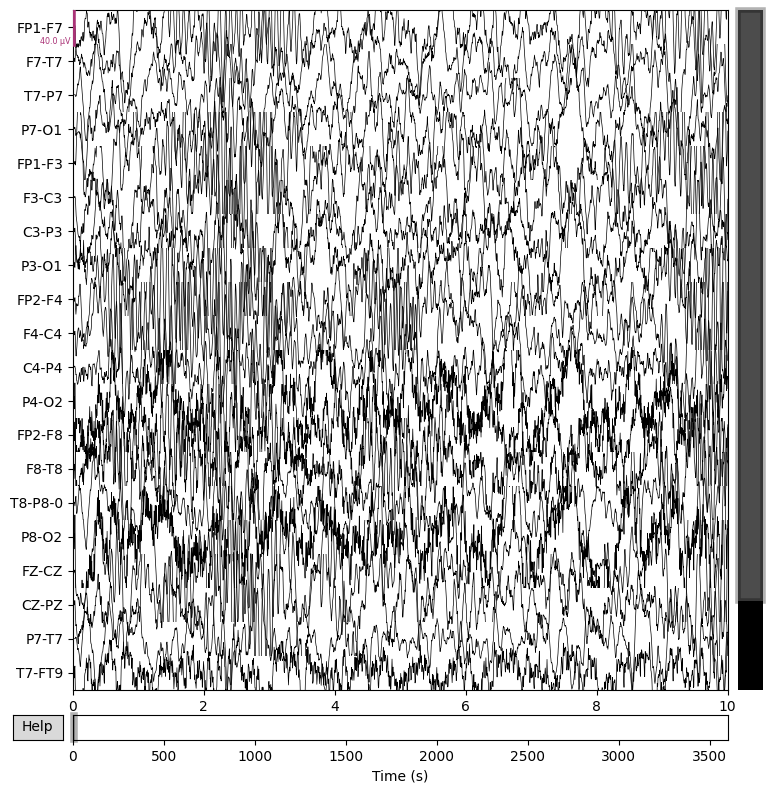

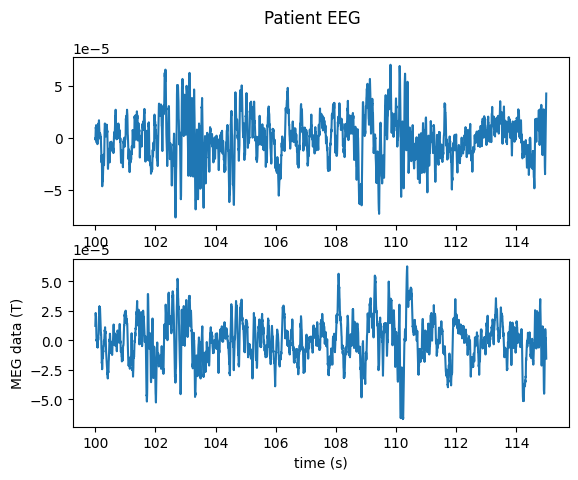

In [ ]:

eeg_visualize(file)